# Home appraisal prediction
Arthur Brouwers
This notebook is about iteration 0 for my personal challenge in semester 4 of AI. It aims to predict the house price correctly. Since I do not know which model I can use the best, I am using nearest neighbors since this was adviced. 

![Alt text](https://www.smartpropertyinvestment.com.au/images/intro-images/839x487/property-financing-prices-spi.jpg)

In [315]:
import io, math
from scipy.io import arff
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error      
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd


Now let's import the found dataset

In [316]:
columns = ["Address", "City", "Price", "Lot size (m2)", "Living space size (m2)", "Build year", "Build type", "House type", "Roof", "Rooms", "Toilet", "Floors", "Energy label", "Position", "Garden", "Estimated neighbourhood price per m2"]
df = pd.read_csv("C:/school/leerjaar 2/semester 4/Personal challenge/raw_data.csv", names=columns)
df.shape

(5556, 16)

In [317]:
print(df.isna().sum())


Address                                   0
City                                      0
Price                                     0
Lot size (m2)                             0
Living space size (m2)                    0
Build year                               84
Build type                                0
House type                                0
Roof                                      0
Rooms                                     0
Toilet                                    0
Floors                                    0
Energy label                              0
Position                                304
Garden                                   58
Estimated neighbourhood price per m2    169
dtype: int64


As you can see some of the values are missing (if it does not say 0, there is possibly missing data). So it is necessary to clean the dataset. 

In [318]:
df.shape
df.sample(10)

,Address,City,Price,Lot size (m2),Living space size (m2),Build year,Build type,House type,Roof,Rooms,Toilet,Floors,Energy label,Position,Garden,Estimated neighbourhood price per m2
3715,Zutphenseweg 8,Lochem,€ 775.000,450 m²,205 m²,1920,Bestaande bouw,"Herenhuis, vrijstaande woning",Schilddak bedekt met pannen,8 kamers (4 slaapkamers),2 badkamers,2 woonlagen en een zolder,C,Aan drukke weg en aan park,"Achtertuin, voortuin en zijtuin",3.910
4549,Tuilland 17,Doorn,€ 390.000,234 m²,85 m²,1956,Bestaande bouw,"Eengezinswoning, hoekwoning",Zadeldak bedekt met pannen,5 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen,E,"Aan rustige weg, in bosrijke omgeving en in wo...","Achtertuin, voortuin en zijtuin",1.325
5204,Wijnruit 40,Oosterhout (NB),€ 889.000,713 m²,212 m²,1978,Bestaande bouw,"Villa, vrijstaande woning",Samengesteld dak bedekt met pannen,7 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,2 woonlagen,C,In woonwijk,"Achtertuin, voortuin en zijtuin",1.865
5032,Kruisweg 8,Middelburg,€ 399.000,331 m²,136 m²,1961,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,7 kamers (5 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen en een vliering,C,In woonwijk,"Achtertuin, voortuin en zijtuin",1.215
2335,Badhuisstraat 30,Bergambacht,€ 419.000,303 m²,109 m²,1955,Bestaande bouw,"Eengezinswoning, hoekwoning",Zadeldak bedekt met pannen,6 kamers (5 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen,D,In woonwijk,"Achtertuin, voortuin en zijtuin",3.270
2355,Zuiderhaven 43,Harlingen,€ 697.500,140 m²,277 m²,1872,Bestaande bouw,"Grachtenpand, tussenwoning",Zadeldak bedekt met pannen,9 kamers (5 slaapkamers),3 badkamers en 1 apart toilet,5 woonlagen,A,Aan vaarwater en in centrum,Zonneterras,3.165
4923,Hunnenpad 14,Putten,€ 995.000,1.805 m²,161 m²,1989,Bestaande bouw,"Villa, vrijstaande woning",Samengesteld dak bedekt met bitumineuze dakbed...,4 kamers (3 slaapkamers),2 badkamers,2 woonlagen,B,"Aan bosrand, aan rustige weg, beschutte liggin...",Tuin rondom,2.610
2587,De Oude Munt 111,Amersfoort,€ 425.000,115 m²,114 m²,1995,Bestaande bouw,"Eengezinswoning, tussenwoning",Zadeldak bedekt met pannen,6 kamers (5 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen en een vliering,B,"Aan rustige weg, in woonwijk en vrij uitzicht",Achtertuin en voortuin,3.080
4506,Hortensia 13,Dirksland,€ 585.000,425 m²,152 m²,2005,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Zadeldak bedekt met pannen,4 kamers (3 slaapkamers),2 badkamers en 1 apart toilet,2 woonlagen,B,Aan rustige weg,Tuin rondom,1.775
65,Zandhovenstraat 4,Breda,€ 325.000,179 m²,127 m²,1968,Bestaande bouw,"Eengezinswoning, tussenwoning",Dwarskap bedekt met pannen,6 kamers (4 slaapkamers),1 badkamer en 1 apart toilet,3 woonlagen en een vliering,C,Aan water en in woonwijk,Achtertuin en voortuin,4.260


As you can see here, there are a few more problems with the data:
- € in price
- m2 in Lot size
- m2 in Living space size
- .0 in Build year
- Multiple values in House type
- Multiple values in Rooms
- Multiple values in Toilet


In [319]:
# Convert "Price" column to a string type
df['Price'] = df['Price'].astype(str)
# Exclude rows with "Voor 1906" in the "Build year" column
df = df[df['Build year'] != "Voor 1906"]
df = df[df['Build year'] != "Na 2020"]
df['Total rooms'] = df['Rooms'].str.extract(r'(\d+) kamers')
df['Bedrooms'] = df['Rooms'].str.extract(r'(\d+) slaapkamers')
df['Bathrooms'] = df['Toilet'].str.extract(r'(\d+) badkamer').fillna(0).astype(int)
df['Toilets'] = df['Toilet'].str.extract(r'(\d+) aparte toiletten').fillna(0).astype(int)
df.loc[df['Toilet'].str.contains('1 apart toilet', case=False), 'Toilets'] = 1

df['Bathrooms'].fillna(0, inplace=True)
df['Toilets'].fillna(0, inplace=True)

df.drop('Toilet', axis=1, inplace=True)


# Remove thousands separator (period) and convert to float
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d.]', '', regex=True).str.replace('.', '', regex=False), errors='coerce')
df['Estimated neighbourhood price per m2'] = df['Estimated neighbourhood price per m2'].str.replace('[^\d.]', '', regex=True)
df['Estimated neighbourhood price per m2'] = pd.to_numeric(df['Estimated neighbourhood price per m2'], errors='coerce')

df['Floors'] = df['Floors'].str.extract(r'(\d+)').astype(float)

# Remove "m²" from the "Lot size (m2)" and "Living space size (m2)" columns
df['Lot size (m2)'] = df['Lot size (m2)'].str.replace('m²', '').str.strip()
df['Lot size (m2)'] = pd.to_numeric(df['Lot size (m2)'].str.replace('[^\d.]', '', regex=True), errors='coerce')

df['Living space size (m2)'] = df['Living space size (m2)'].str.replace('m²', '').str.strip()
df['Living space size (m2)'] = pd.to_numeric(df['Living space size (m2)'].str.replace('[^\d.]', '', regex=True), errors='coerce')

# Define the mapping for Energy labels
label_mapping = {
    'A++++': 1,
    'A+++': 2,
    'A++': 3,
    'A+': 4,
    'A': 5,
    'B': 6,
    'C': 7,
    'D': 8,
    'E': 9,
    'F': 10,
    'G': 11
}

# Remove 'Niet verplicht' rows
df = df[df['Energy label'] != 'Niet verplicht']

# Map the Energy labels to numeric values
df['Energy label'] = df['Energy label'].map(label_mapping)

# Drop rows with NaN values in the "Price" column
df = df.dropna(subset=['Price'])
df = df.drop(columns=['Rooms'])
# Reset index if needed
df = df.reset_index(drop=True)

df.shape
df.sample(10)


,Address,City,Price,Lot size (m2),Living space size (m2),Build year,Build type,House type,Roof,Floors,Energy label,Position,Garden,Estimated neighbourhood price per m2,Total rooms,Bedrooms,Bathrooms,Toilets
1113,Van Doesburg-erf 77,Dordrecht,450000.0,205.0,155,1991,Bestaande bouw,"Eengezinswoning, hoekwoning",Samengesteld dak bedekt met pannen,3.0,6.0,NaN,Achtertuin en voortuin,2.720,7,6,1,1
5223,Pastoor Swelsenstraat 12,Geulle,300000.0,379.0,140,1972,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,3.0,8.0,Aan rustige weg,Achtertuin en voortuin,880.000,7,4,1,2
4625,Horsterweg 23,Leusden,1100000.0,647.0,213,1998,Bestaande bouw,"Eengezinswoning, vrijstaande woning",Schilddak bedekt met pannen,3.0,6.0,In woonwijk en vrij uitzicht,Tuin rondom,1.790,7,4,2,2
1600,Edelhertweg 41,Almere,425000.0,141.0,135,1994.0,Bestaande bouw,"Herenhuis, tussenwoning",Plat dak,2.0,6.0,"Aan rustige weg, in woonwijk en vrij uitzicht",Achtertuin en voortuin,4.435,4,3,1,1
4497,Tuilland 17,Doorn,390000.0,234.0,85,1956,Bestaande bouw,"Eengezinswoning, hoekwoning",Zadeldak bedekt met pannen,3.0,9.0,"Aan rustige weg, in bosrijke omgeving en in wo...","Achtertuin, voortuin en zijtuin",1.325,5,4,1,1
908,Jaagpad 51,Etten-Leur,579000.0,180.0,154,2002,Bestaande bouw,"Herenhuis, geschakelde woning",Plat dak bedekt met bitumineuze dakbedekking,3.0,5.0,"Aan park, aan rustige weg, aan vaarwater, aan ...",Achtertuin en voortuin,3.660,6,5,1,1
708,Merlijnshof 30,Prinsenbeek,400000.0,209.0,139,1975,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,2.0,7.0,NaN,Achtertuin en voortuin,11.035,5,4,2,1
1446,Monnetstraat 10,Zevenaar,350000.0,228.0,114,1985.0,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,3.0,7.0,Aan rustige weg en in woonwijk,Achtertuin,2.905,5,4,1,1
4791,Juliana van Stolberglaan 47,Den Haag,1275000.0,251.0,380,1917,Bestaande bouw,"Herenhuis, tussenwoning",Samengesteld dak,4.0,9.0,NaN,Achtertuin,4.645,12,9,1,4
2024,Ottersveen 105,Spijkenisse,310000.0,158.0,121,1974,Bestaande bouw,"Eengezinswoning, tussenwoning",Zadeldak bedekt met pannen,3.0,8.0,Aan rustige weg en in woonwijk,Achtertuin en voortuin,470.000,4,3,1,1


In [320]:
df["Energy label"].unique()

array([ 8.,  9.,  6.,  5.,  7., 11., 10.,  2.,  3.,  4.,  1.])

In [321]:
numeric_features = ['Price', "Lot size (m2)", "Living space size (m2)", "Build year", "Floors", "Energy label", "Estimated neighbourhood price per m2", "Total rooms", "Bedrooms", "Bathrooms", "Toilets"]
target = "Price"
X = df[numeric_features]
y = df[target]

In [322]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 5474 observations, of which 4379 are now in the train set, and 1095 in the test set.


# Feature Selection
I will use a heatmap to select a suitable set of features to make predictions. 

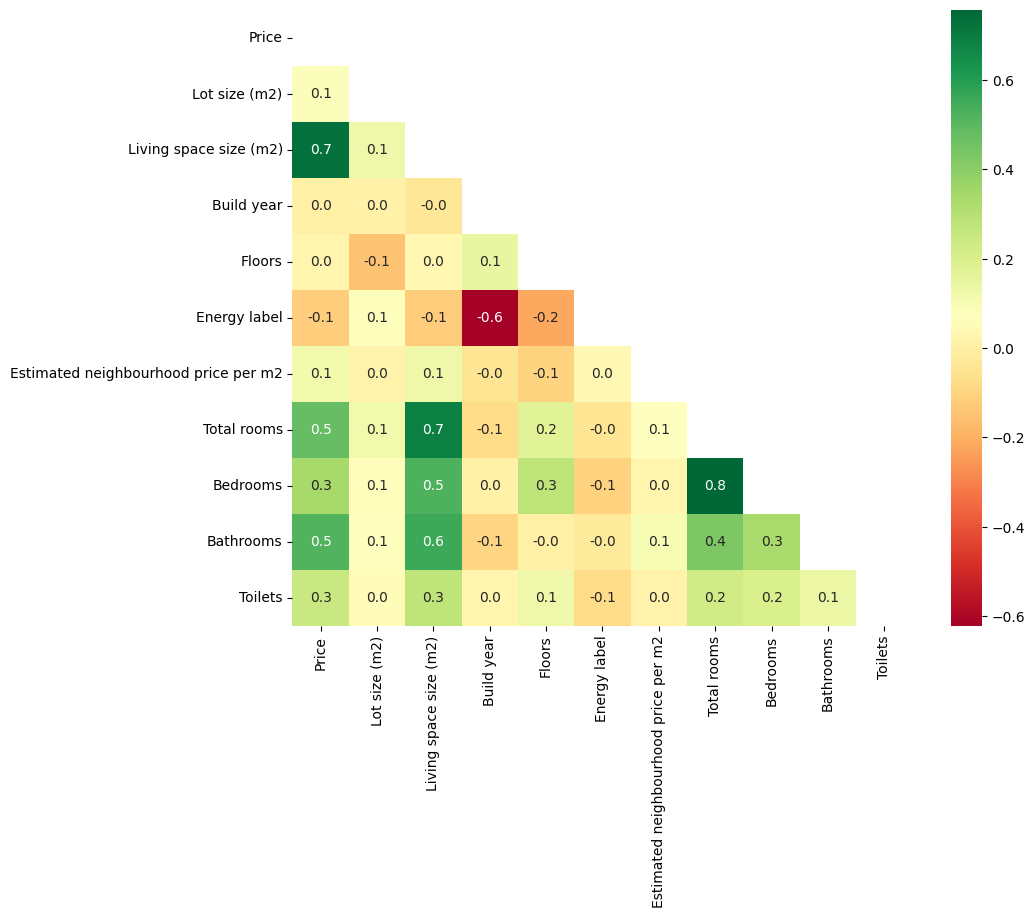

In [323]:
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 8))

# Choose a color map (e.g., 'coolwarm', 'viridis', 'RdYlGn', etc.)
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Calculate correlations and create the heatmap
correlations = X_train.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plot = sns.heatmap(correlations, cbar=True, annot=True, fmt=".1f", cmap=cmap, mask=mask)

# Customize annot_kws (font size and color)
annot_kws = {"size": 12, "color": 'black'}
plot.set_yticklabels(plot.get_yticklabels(), rotation=0)

plt.show()


# Scatterplot

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


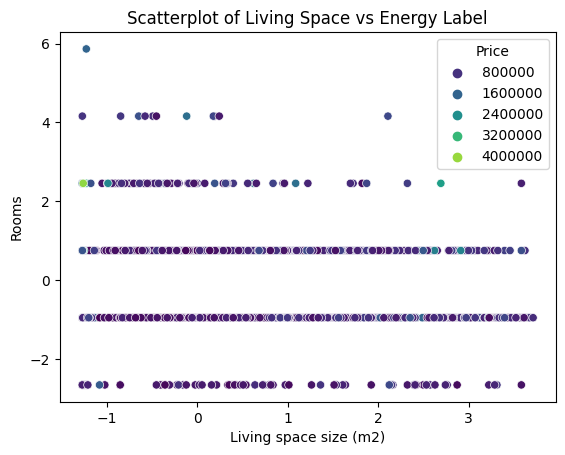

In [324]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


plot = sns.scatterplot(x=X_train[:,1], y=X_train[:,4], hue=y_train, palette="viridis")
plot.set(xlabel="Living space size (m2)", ylabel="Rooms", title="Scatterplot of Living Space vs Energy Label")
plot.legend(title="Price")

# Create the scatterplot




# Accuracy
What is the accuracy and how did I get the best K-value?

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 5474 observations, of which 4379 are now in the train set, and 1095 in the test set.


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.

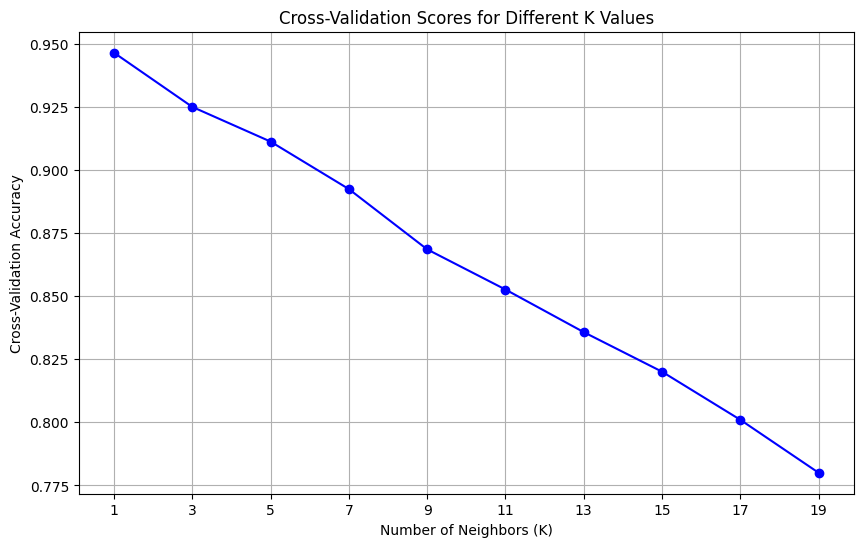

Best K value: 1


In [326]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]
X_test.dropna(inplace=True)
y_test = y_test[X_test.index]
y_test = pd.to_numeric(y_test)

k_values = list(range(1, 20, 2))
cv_scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # You can adjust the number of folds (cv) as needed
    cv_scores.append(scores.mean())
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Scores for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# print which K value results in the highest cross-validation score
best_k = k_values[np.argmax(cv_scores)]
print(f'Best K value: {best_k}')

In [327]:
# train model with the best K value
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

In [328]:
test_accuracy = best_model.score(X_test, y_test)
print(f'Accuracy on test data with the best K: {test_accuracy:.4f}')


Accuracy on test data with the best K: 0.9441


# Linear regression


In [329]:
features = ["Living space size (m2)", "Bathrooms", "Total rooms"]
target = "Price"

X = df[features]
y = df[target]

In [330]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 5474 observations, of which 4379 are now in the train set, and 1095 in the test set.


In [331]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("R²:", score)

R²: 0.5461597305093054


In [332]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,450000.0,3.988826e+05,51117
1,1150000.0,8.089674e+05,341032
2,625000.0,6.840191e+05,59019
3,795000.0,8.960698e+05,101069
4,325000.0,3.377203e+05,12720
...,...,...,...
1090,450000.0,6.180419e+05,168041
1091,199500.0,2.932164e+05,93716
1092,2395000.0,1.342832e+06,1052168
1093,1050000.0,5.891923e+05,460807


<Axes: xlabel='predicted price', ylabel='true price'>

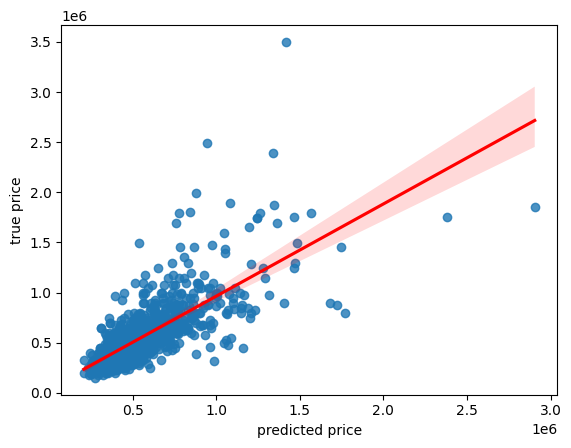

In [333]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted price")
plot.set_ylabel("true price")
plot

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

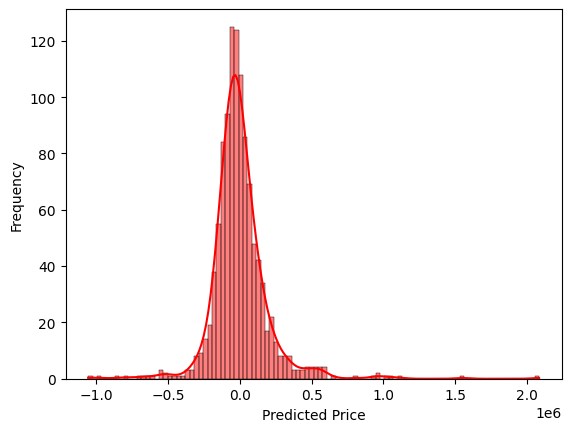

In [334]:
plot = sns.histplot(x=(y_test - predictions).values.flatten(), kde=True, color="r")
plot.set_xlabel("Predicted Price")
plot.set_ylabel("Frequency")

In [335]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 2083815
Root Mean Squared Error: 200692


# Clustering

Price
450000.0    183
375000.0    179
350000.0    160
325000.0    158
425000.0    152
           ... 
839500.0      1
443000.0      1
262500.0      1
422000.0      1
366000.0      1
Name: count, Length: 536, dtype: int64


<Axes: xlabel='Price'>

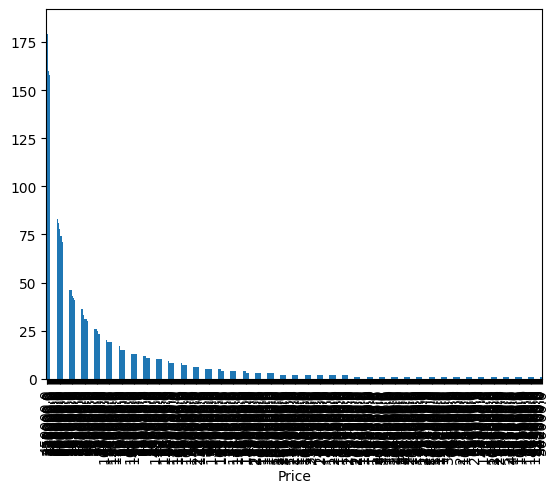

In [336]:
print(df['Price'].value_counts())
df['Price'].value_counts().plot(kind='bar')

In [337]:
df.describe()

,Price,Lot size (m2),Living space size (m2),Floors,Energy label,Estimated neighbourhood price per m2,Bathrooms,Toilets
count,5.474000e+03,5474.000000,5474.000000,5474.000000,5474.000000,5305.000000,5474.000000,5474.000000
mean,5.539167e+05,256.924877,145.496894,2.555901,6.924552,102.685205,1.210632,1.092072
std,3.475459e+05,201.268544,60.750090,0.586933,1.761903,245.084056,0.483255,0.488792
min,1.490000e+05,1.000000,53.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.600000e+05,134.000000,110.000000,2.000000,5.000000,2.045000,1.000000,1.000000
50%,4.650000e+05,198.000000,130.000000,3.000000,7.000000,3.470000,1.000000,1.000000
75%,6.350000e+05,323.000000,161.000000,3.000000,8.000000,6.825000,1.000000,1.000000
max,4.700000e+06,998.000000,844.000000,6.000000,11.000000,995.000000,7.000000,4.000000


In [338]:
from sklearn.preprocessing import StandardScaler


# Use this line to select all features
X_House = df[["Price", "Lot size (m2)", "Living space size (m2)", "Build year", "Floors", "Energy label", "Estimated neighbourhood price per m2", "Total rooms", "Bedrooms", "Bathrooms", "Toilets"]]

y_House = df['Price']
print('Price types:', y_House.unique())

# Normalize the data
scaler_House = StandardScaler().fit(X_House)
X_House_normalized = scaler_House.transform(X_House)
print('The length of X_House_normalized: ', len(X_House))


Price types: [ 525000.  425000.  575000.  259500. 1050000.  445000.  825000.  249500.
  550000.  859000.  389000.  349000.  399000.  495000.  560000.  415000.
  310000.  289000.  385000.  325000.  485000.  335000.  315000.  675000.
  275000.  595000.  450000.  540000.  359000.  165000.  375000.  615000.
  420000.  300000.  650000.  299000.  267500.  545000.  945000.  462500.
  395000.  249000.  599000.  979000. 1250000.  479000.  845000.  350000.
  750000.  739000.  369000.  355000.  850000.  427500.  239500.  649000.
  579000.  285000.  390000.  749000.  419000.  689000.  530000.  539000.
  429900.  600000.  800000. 1175000.  295000.  365000.  250000.  975000.
  685000.  287500.  435000.  725000.  775000.  475000.  279500.  219000.
 1150000.  340000.  319000.  399500.  330000.  298000.  549000.  294000.
  695000.  698000.  279000.  509000.  245000.  925000.  269000. 1295000.
  795000.  379000.  400000.  360000. 1198000. 1100000.  339000.  625000.
  150000. 2925000.  210000.  195000.  

Number of selected features:  11


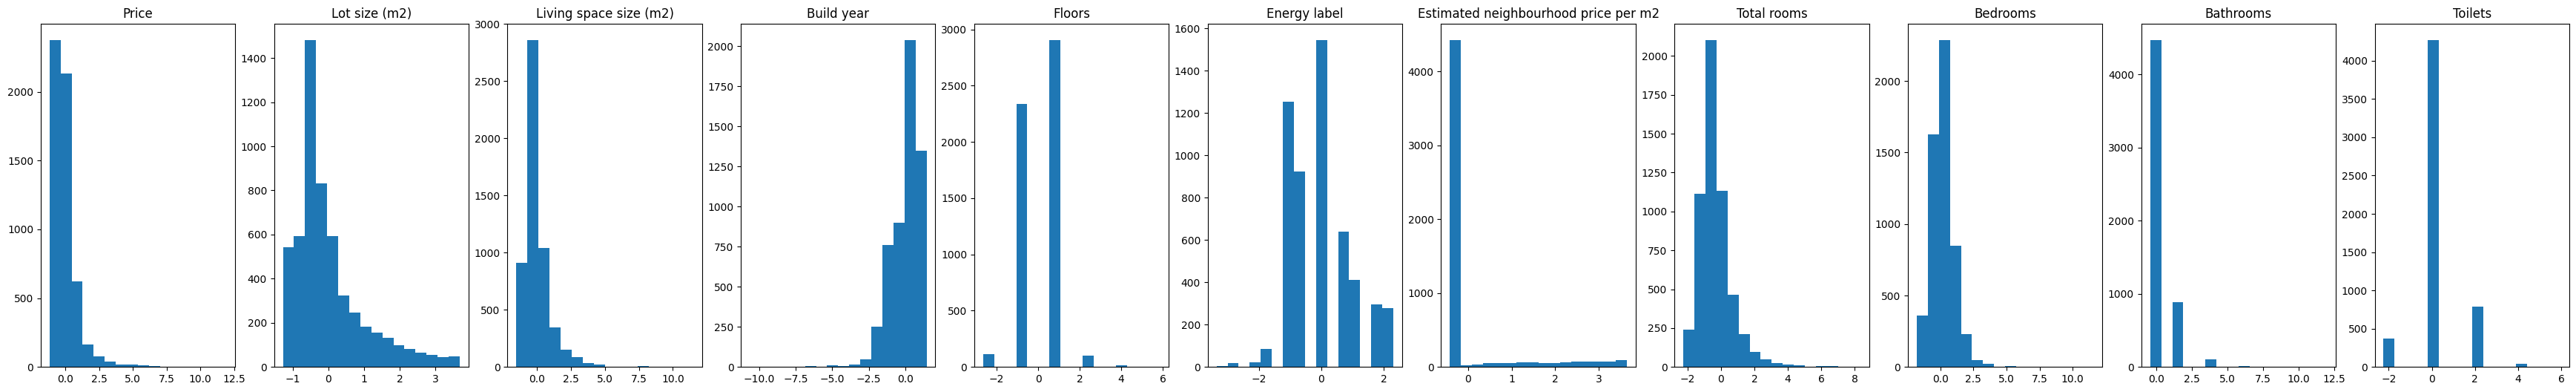

In [339]:
# Define number of bins for histogram
nbins = 16

# Number of selected features
nfeatures = len(X_House.columns)
print('Number of selected features: ',nfeatures)

# Plot histograms for each of the selected features
fig, axs = plt.subplots(1,nfeatures,figsize=(nfeatures*4,6))
for feature in range(nfeatures):
    axs[feature].hist(X_House_normalized[:,feature],nbins)
    axs[feature].set_title(X_House.columns[feature])

In [343]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Check for NaN values in the NumPy array
nan_indices = np.argwhere(np.isnan(X_House_normalized))

# Impute NaN values with the mean of the respective column
for row, col in nan_indices:
    X_House_normalized[row, col] = np.nanmean(X_House_normalized[:, col])


# Define number of clusters by setting distance threshold
agglom = AgglomerativeClustering(distance_threshold=10, n_clusters=None)

# Use this line for agglomerative clustering using normalized data
agglom.fit(X_House_normalized)



AgglomerativeClustering(distance_threshold=10, n_clusters=None)

In [344]:
n_clusters = agglom.n_connected_components_
print('Number of clusters: ', n_clusters)


Number of clusters:  1


In [345]:
print('Number of clusters: ',agglom.n_clusters_)

Number of clusters:  122


(array([4.915e+03, 3.840e+02, 8.300e+01, 3.400e+01, 2.000e+01, 1.000e+01,
        5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,   3.99053812,   7.98107624,  11.97161436,
         15.96215248,  19.9526906 ,  23.94322872,  27.93376684,
         31.92430496,  35.91484308,  39.90538121,  43.89591933,
         47.88645745,  51.87699557,  55.86753369,  59.85807181,
         63.84860993,  67.83914805,  71.82968617,  75.82022429,
         79.81076241,  83.80130053,  87.79183865,  91.78237677,
         95.77291489,  99.76345301, 103.75399113, 107.74452925,
        111.73506737, 115.7256055 , 119.71614362]),
 <BarContainer object of 30 artists>)

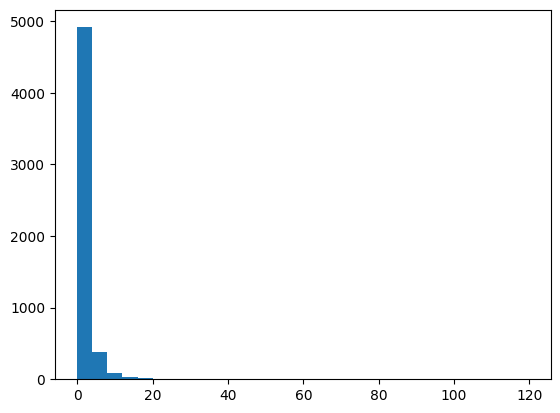

In [346]:
plt.hist(agglom.distances_,30)

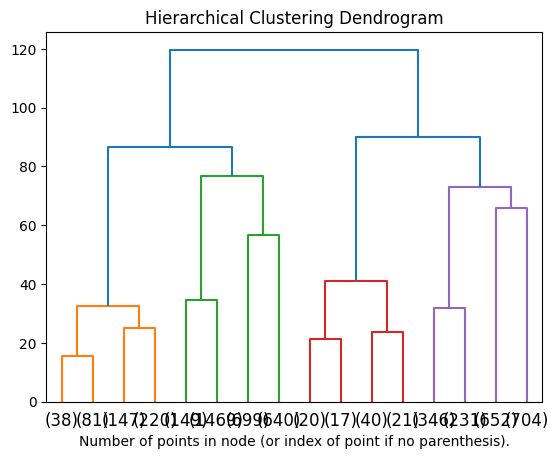

In [347]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglom, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [349]:
df['Cluster'] = agglom.labels_.astype(str)
df['Cluster'] = 'Cluster ' + df['Cluster']
df.head(5)

,Address,City,Price,Lot size (m2),Living space size (m2),Build year,Build type,House type,Roof,Floors,Energy label,Position,Garden,Estimated neighbourhood price per m2,Total rooms,Bedrooms,Bathrooms,Toilets,Cluster
0,Bovenweg 223,Sint Pancras,525000.0,251.0,135,1972,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,3.0,8.0,NaN,"Achtertuin, voortuin en zijtuin",6.035,5,4,1,1,Cluster 32
1,Julianastraat 19,Waddinxveen,425000.0,181.0,109,1935,Bestaande bouw,"Herenhuis, geschakelde 2-onder-1-kapwoning",Schilddak bedekt met bitumineuze dakbedekking ...,3.0,9.0,Aan rustige weg en in woonwijk,Achtertuin en voortuin,1.435,4,3,1,1,Cluster 116
2,Kuipersgilde 3,Houten,575000.0,198.0,138,1986,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,3.0,6.0,Aan rustige weg en in woonwijk,Achtertuin,1.855,5,4,1,1,Cluster 29
3,De Kamp 1 A,Pannerden,259500.0,231.0,92,1989,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Zadeldak bedekt met pannen,3.0,6.0,Aan rustige weg en in woonwijk,"Achtertuin, voortuin en zijtuin",2.190,5,3,1,2,Cluster 35
4,Wildrijklaan 8,Sassenheim,1050000.0,423.0,210,2000,Bestaande bouw,"Eengezinswoning, 2-onder-1-kapwoning",Schilddak bedekt met pannen,4.0,5.0,"Aan rustige weg, aan water, beschutte ligging,...","Achtertuin, voortuin en zijtuin",1.340,6,5,2,2,Cluster 2


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Figure size 800x800 with 0 Axes>

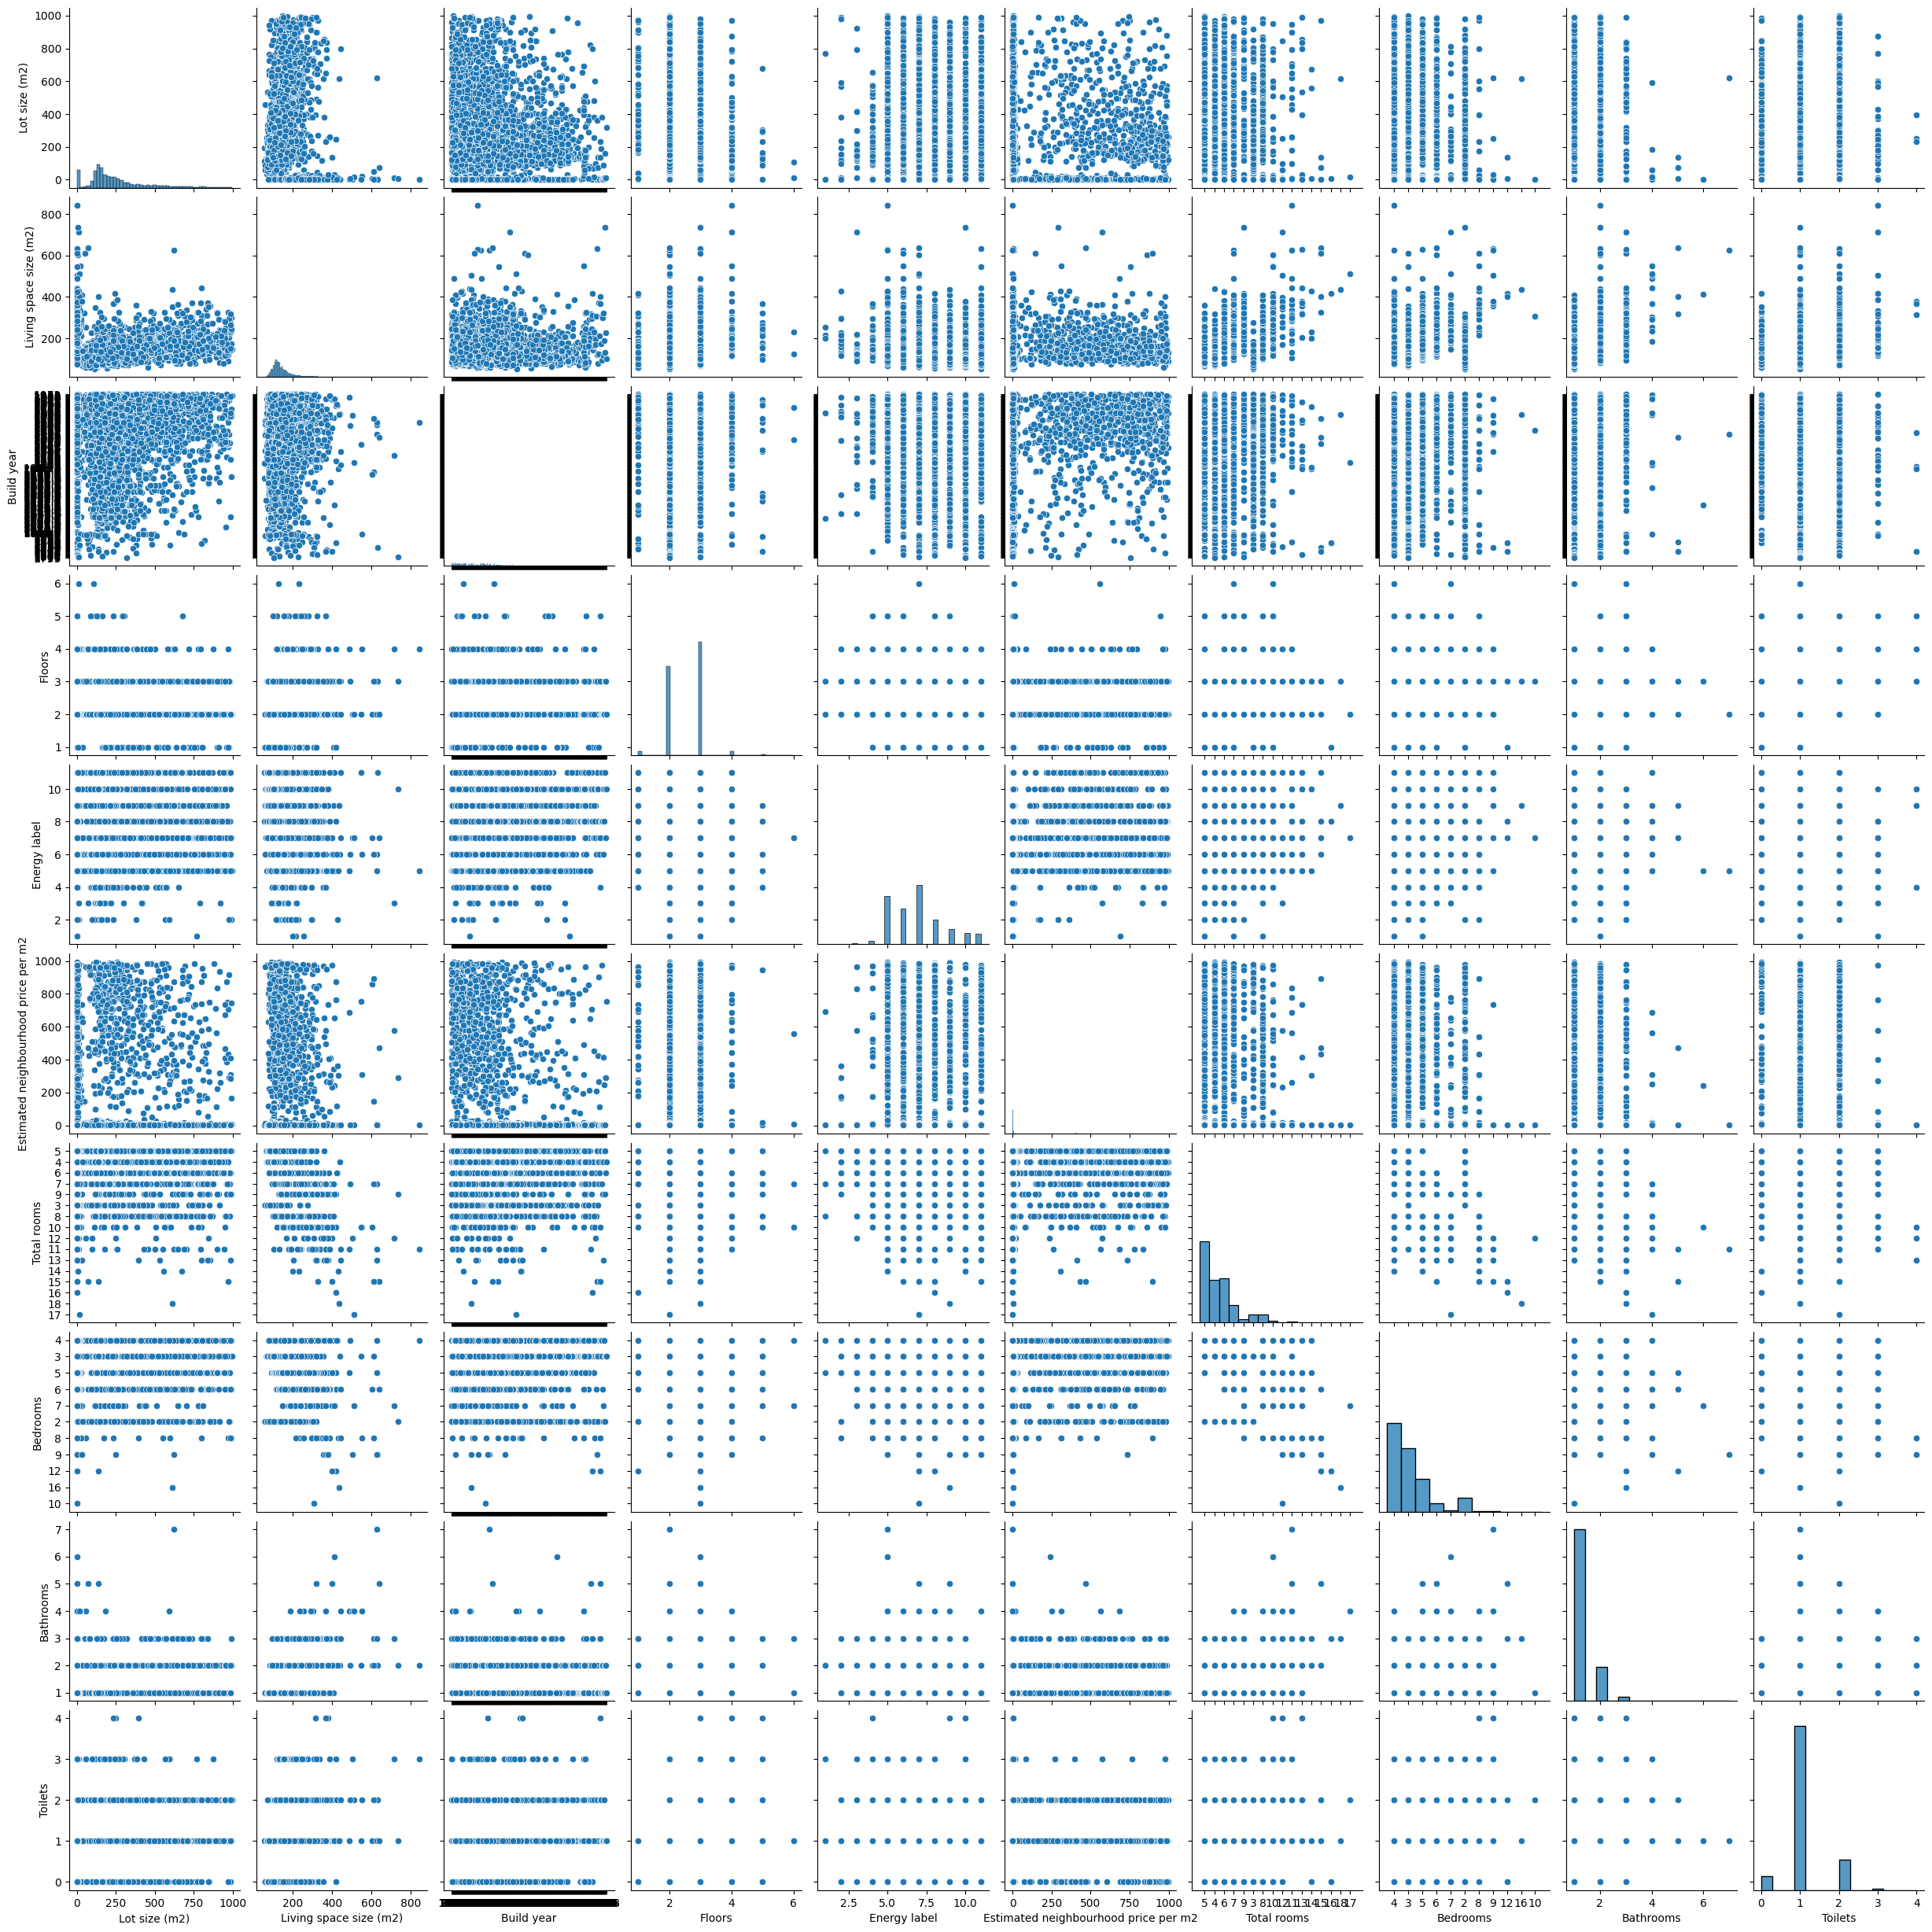

In [353]:
df_clean = df[["Price", "Lot size (m2)", "Living space size (m2)", "Build year", "Floors", "Energy label", "Estimated neighbourhood price per m2", "Total rooms", "Bedrooms", "Bathrooms", "Toilets"]].dropna()
df_clean["Price"] = pd.to_numeric(df_clean["Price"], errors="coerce")
df_clean = df_clean.dropna()  # Remove rows with missing data

df_numeric = df_clean.select_dtypes(include=['number'])

plt.figure(figsize=(8, 8))
ax = sns.pairplot(df_clean, vars=["Lot size (m2)", "Living space size (m2)", "Build year", "Floors", "Energy label", "Estimated neighbourhood price per m2", "Total rooms", "Bedrooms", "Bathrooms", "Toilets"])
plt.show()
